In [2]:
import numpy as np # data analysis
import pandas as pd # data processing, CSV file reading
import matplotlib.pyplot as plt #plotting and charts
import seaborn as sns #prettier charts, some extra features

#normally
from sklearn.preprocessing import LabelEncoder #couldn't figure out the dummy variables in pandas, this was next best
from sklearn.preprocessing import StandardScaler #someone told me about this, scales everything so scores are 0-100 / 0-1
from sklearn.model_selection import train_test_split #getting tired of sk learn here
from sklearn.linear_model import LogisticRegression #ML logistic regression
from sklearn.tree import DecisionTreeClassifier # DCT ML
from sklearn.ensemble import RandomForestClassifier #Finally random forest plz no more sklearn kits


%matplotlib inline 

In [3]:
train = pd.read_csv('train.csv') #reads in folder, should I figure out other solutions?
test = pd.read_csv('test.csv') #test file

In [4]:
print(train['Embarked'].unique())

['S' 'C' 'Q' nan]


In [5]:
train.describe() #seeing the data with some typical metrics, age obviously has missing values, nothing else looks weird

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<AxesSubplot:>

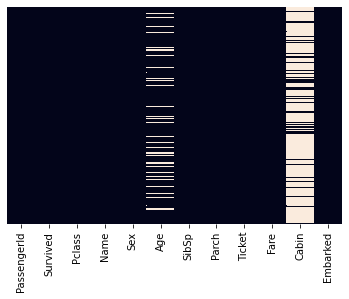

In [6]:
sns.heatmap(train.isnull(), yticklabels = False, cbar = False,) #visual for null values in the data, sns makes nice graphs

In [7]:
train.info() #essentially same as above, cabin and age have the most null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


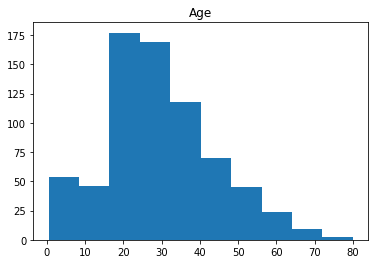

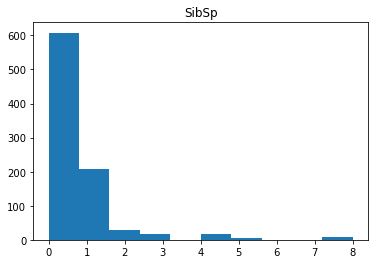

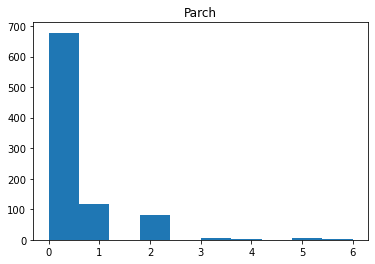

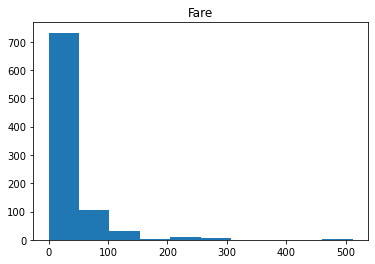

In [8]:
df_num = train[['Age','SibSp','Parch','Fare']] #numeric variables for train
df_cat = train[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']] #categorical for train


for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

In [9]:
print(df_num.corr()) #nothing interesting, only a moderate relationship

            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


In [10]:
corr = train.corr()
corr.style.background_gradient(cmap='Blues').set_precision(2) #this is a bigger set but still, nothing eye catching

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.00,-0.01,-0.04,0.04,-0.06,-0.00,0.01
Survived,-0.01,1.00,-0.34,-0.08,-0.04,0.08,0.26
Pclass,-0.04,-0.34,1.00,-0.37,0.08,0.02,-0.55
Age,0.04,-0.08,-0.37,1.00,-0.31,-0.19,0.10
SibSp,-0.06,-0.04,0.08,-0.31,1.00,0.41,0.16
Parch,-0.00,0.08,0.02,-0.19,0.41,1.00,0.22
Fare,0.01,0.26,-0.55,0.10,0.16,0.22,1.00


<AxesSubplot:xlabel='Survived', ylabel='count'>

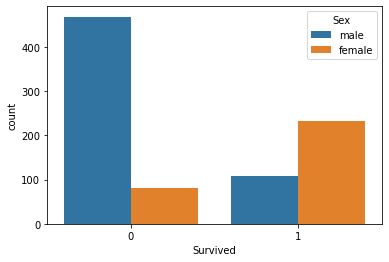

In [11]:
sns.countplot(x = "Survived", hue = "Sex", data = train) #confirms women survived a lot more than men did

In [12]:
train.groupby('Sex')[['Survived']].mean() #definitely confirms it

,Survived
Sex,
female,0.742038
male,0.188908


<AxesSubplot:xlabel='Survived', ylabel='count'>

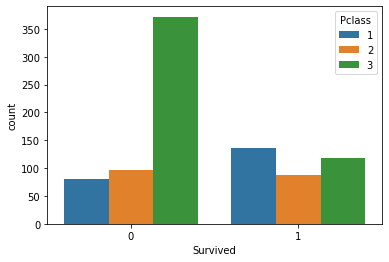

In [13]:
sns.countplot(x = "Survived", hue = "Pclass", data = train) #confirms 1st class had a good chance for surviving

<AxesSubplot:xlabel='Embarked', ylabel='count'>

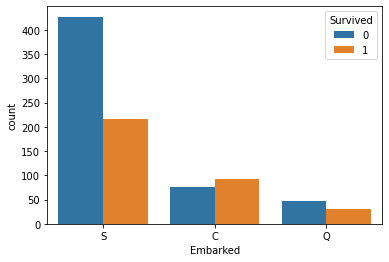

In [14]:
sns.countplot(x = "Embarked", hue = "Survived", data = train) #interesting, though given the numbers maybe not significant?

<AxesSubplot:xlabel='Age', ylabel='Density'>

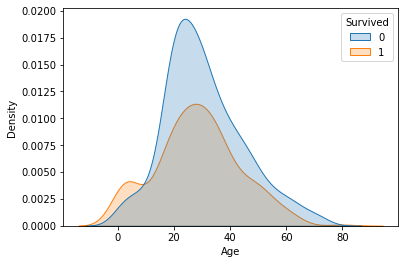

In [15]:
sns.kdeplot(x='Age', hue='Survived', data= train, fill=True) #Is this correct?


Data processing for the model

1. convert everything so sk can read it?
2. I am going to exclude the cabin data, but the age data nulls might be enough to affect results. Should I just average it for the nulls or exclude?<--
3. run the model (success criteria is > 60%)
4. add fancier models and try to clean it a bit from there also how tf do I get the test data used

In [16]:
train.drop(['Cabin','PassengerId','Name', 'Ticket'], axis=1,inplace=True) #dropping unused/difficult data

train = train.dropna(subset =['Embarked', 'Age'])


In [17]:
train.dtypes #quick check on what is left, and the data types, it will probably most useful to work with objects


Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [18]:
test.drop(['Cabin','PassengerId','Name', 'Ticket'], axis=1,inplace=True) #trying to make the test data usable

test = test.dropna(subset =['Embarked', 'Age'])

test.dtypes

Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

From here I am going to try to fit the data into the sklearn modules, I called them all at the beginning, but will reference them. JN is weird in how it calls stuff, still figuring that out but onward. Also, to be very clear, 

--> survived is the DV, everything else is an IV

In [19]:
train.head() # this shows me the rows and columns for the next part

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [20]:

Encoder = LabelEncoder()

#Encode sex column
train.iloc[:,2]= Encoder.fit_transform(train.iloc[:,2].values)
#print(labelencoder.fit_transform(titanic.iloc[:,2].values))

#Encode embarked
train.iloc[:,7]= Encoder.fit_transform(train.iloc[:,7].values)
#print(labelencoder.fit_transform(titanic.iloc[:,7].values))

#Print to check that the values are now ready for data(this part took so long I hated it)
print(train['Sex'].unique())
print(train['Embarked'].unique())

[1 0]
[2 0 1]


In [21]:
IV = train.iloc[:, 1:8].values #separate for IV and DV predictions I think this is correct

DV = train.iloc[:, 0].values

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(IV, DV, test_size = 0.2, random_state = 0)

Scale = StandardScaler() #this was needed to stop breaking my machine when running the tests
X_train = Scale.fit_transform(X_train)
X_test = Scale.transform(X_test)

In [23]:
#This is crazy
def models(X_train,Y_train):
  
  #Using Logistic Regression Algorithm to the Training Set
  from sklearn.linear_model import LogisticRegression
  log = LogisticRegression(random_state = 0)
  log.fit(X_train, Y_train)
  
  #Using KNeighborsClassifier Method of neighbors class to use Nearest Neighbor algorithm
  from sklearn.neighbors import KNeighborsClassifier
  knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
  knn.fit(X_train, Y_train)

  #Using SVC method of svm class to use Support Vector Machine Algorithm
  from sklearn.svm import SVC
  svc_lin = SVC(kernel = 'linear', random_state = 0)
  svc_lin.fit(X_train, Y_train)

  #Using SVC method of svm class to use Kernel SVM Algorithm
  from sklearn.svm import SVC
  svc_rbf = SVC(kernel = 'rbf', random_state = 0)
  svc_rbf.fit(X_train, Y_train)

  #Using GaussianNB method of naïve_bayes class to use Naïve Bayes Algorithm
  from sklearn.naive_bayes import GaussianNB
  gauss = GaussianNB()
  gauss.fit(X_train, Y_train)

  #Using DecisionTreeClassifier of tree class to use Decision Tree Algorithm
  from sklearn.tree import DecisionTreeClassifier
  tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
  tree.fit(X_train, Y_train)

  #Using RandomForestClassifier method of ensemble class to use Random Forest Classification algorithm
  from sklearn.ensemble import RandomForestClassifier
  forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
  forest.fit(X_train, Y_train)
  
  #print model accuracy on the training data.
  print('[0]Logistic Regression Training Accuracy:', log.score(X_train, Y_train))
  print('[1]K Nearest Neighbor Training Accuracy:', knn.score(X_train, Y_train))
  print('[2]Support Vector Machine (Linear Classifier) Training Accuracy:', svc_lin.score(X_train, Y_train))
  print('[3]Support Vector Machine (RBF Classifier) Training Accuracy:', svc_rbf.score(X_train, Y_train))
  print('[4]Gaussian Naive Bayes Training Accuracy:', gauss.score(X_train, Y_train))
  print('[5]Decision Tree Classifier Training Accuracy:', tree.score(X_train, Y_train))
  print('[6]Random Forest Classifier Training Accuracy:', forest.score(X_train, Y_train))
  
  return log, knn, svc_lin, svc_rbf, gauss, tree, forest

In [24]:
model = models(X_train,Y_train)

[0]Logistic Regression Training Accuracy: 0.7978910369068541
[1]K Nearest Neighbor Training Accuracy: 0.8664323374340949
[2]Support Vector Machine (Linear Classifier) Training Accuracy: 0.7768014059753954
[3]Support Vector Machine (RBF Classifier) Training Accuracy: 0.8506151142355008
[4]Gaussian Naive Bayes Training Accuracy: 0.8031634446397188
[5]Decision Tree Classifier Training Accuracy: 0.9929701230228472
[6]Random Forest Classifier Training Accuracy: 0.9753954305799648


Applying to the test data?

In [25]:
test.head() #damnit do I have to do all that again to clean it?

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [26]:
test.isnull().sum() #well with so few nulls I actually don't need to do much, I am just gonna drop that 1 fare

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        1
Embarked    0
dtype: int64

In [27]:
test = test.dropna(subset =['Fare']) #this should drop that one, I could also have given avg/median value

In [28]:
model = models(X_test,Y_test) # Should be it? these results are good, DCT and RFC are best

[0]Logistic Regression Training Accuracy: 0.8601398601398601
[1]K Nearest Neighbor Training Accuracy: 0.8531468531468531
[2]Support Vector Machine (Linear Classifier) Training Accuracy: 0.8181818181818182
[3]Support Vector Machine (RBF Classifier) Training Accuracy: 0.8391608391608392
[4]Gaussian Naive Bayes Training Accuracy: 0.7902097902097902
[5]Decision Tree Classifier Training Accuracy: 0.993006993006993
[6]Random Forest Classifier Training Accuracy: 0.972027972027972
